## ORIE 6750 Homework 3 Question 2

In [1]:
import numpy as np
import matplotlib.pyplot as plt
from scipy.special import beta
from scipy.integrate import quad

### (b) Value iteration

In [50]:
# Define function for computing likelihood of y given different belief states

f = lambda theta,r,s: 1/beta(r+1, s-r+1) * theta**(r+1) * (1-theta)**(s-r)

for r in range(H):
    for s in range(H):
        likelihood[r,s] = quad(f, 0, 1, args = (r,s))[0]

In [2]:
# Define function with horizon H as input and optimal values and actions as output

def compute_value(H):
    """
    Input: horizon H
    Output: V = (H+1)^5 dimensional array that records the value iteration
            X = H*(H+1)^4 dimensional array that records the optimal actions
    V[H+1,0,0,0,0] is the value starting from uniform prior on both arms
    """
    
    # initialize arrays for storing value, likelihood, best-arm-to-pull
    K=2
    V = np.zeros((H+1,H+1,H+1,H+1,H+1))
    likelihood = np.zeros((H+1,H+1))
    X = np.zeros((H,H+1,H+1,H+1,H+1))
    
    # compute likelihood (independent of iteration and arm)
    f = lambda theta,r,s: 1/beta(r+1, s-r+1) * theta**(r+1) * (1-theta)**(s-r)
    for r in range(H+1):
        for s in range(H+1):
            likelihood[r,s] = quad(f, 0, 1, args = (r,s))[0]
    
    # compute last-step value ("stop-and-predict")
    for r1 in range(H+1):
        for s1 in range(H+1):
            for r2 in range(H+1):
                for s2 in range(H+1):
                    V[0,r1,s1,r2,s2] = np.amax([(r1+1)/(s1+2), (r2+1)/(s2+2)])

    # value iteration 
    for h in range(1, H+1):

        # reset array for storing Q-factors
        Q = np.zeros((K,H+1,H+1,H+1,H+1))

        # Compute Q-factor for pulling each arm under H^4-dim belief states
        for r_fix in range(H):
            for s_fix in range(H):
                for r in range(H):
                    for s in range(H):
                        # if pull arm 1
                        Q[0,r,s,r_fix,s_fix] = V[h-1,r+1,s+1,r_fix,s_fix]*likelihood[r,s] +\
                                                V[h-1,r,s+1,r_fix,s_fix]*(1-likelihood[r,s])
                        # if pull arm 2
                        Q[1,r_fix,s_fix,r,s] = V[h-1,r_fix,s_fix,r+1,s+1]*likelihood[r,s] +\
                                                V[h-1,r_fix,s_fix,r,s+1]*(1-likelihood[r,s])
        
        # Compute value under each belief state
        for r1 in range(H+1):
            for s1 in range(H+1):
                for r2 in range(H+1):
                    for s2 in range(H+1):

                        # compare the two Q-factors
                        V[h,r1,s1,r2,s2] = np.amax([Q[0,r1,s1,r2,s2], Q[1,r1,s1,r2,s2]])
                        X[h-1,r1,s1,r2,s2] = np.argmax([Q[1,r1,s1,r2,s2], Q[0,r1,s1,r2,s2]])


    return V,X

In [3]:
V,X = compute_value(10)
V.shape

(11, 11, 11, 11, 11)

In [178]:
# Do value iteration for horizons ranging from 1 to 30

value_H = np.zeros(30)

for H in range(30):
    V,_ = compute_value(H+1)
    value_H[H] = V[H+1,0,0,0,0]
    print(H)
    

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


In [179]:
value_H

array([0.58333333, 0.58333333, 0.61111111, 0.61666667, 0.625     ,
       0.62777778, 0.63412698, 0.63595238, 0.63948413, 0.64083333,
       0.64329606, 0.64455404, 0.64633529, 0.64713473, 0.64858937,
       0.64931427, 0.65039477, 0.65095857, 0.65188827, 0.6523572 ,
       0.65309547, 0.65351242, 0.65414479, 0.65450437, 0.65503712,
       0.65533596, 0.65580886, 0.65607914, 0.65648125, 0.65671566])

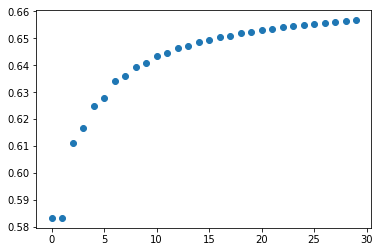

In [181]:
plt.plot(value_H,'o')

### (c) Thompson sampling

In [61]:
def compute_value_Thompson(H, n_iter):
    
    K = 2
    values = np.zeros(n_iter)

    
    for ind_iter in range(n_iter):
        
        B = np.zeros((K,2))    
        
        for n in range(1,H+1):
            #print('time step '+str(n))
            theta_sampled = np.zeros(K)
            for k in range(K):
                theta_sampled[k] = np.random.beta(B[k,0]+1, B[k,1]-B[k,0]+1)
            #print(theta_sampled)
            pull = np.argmax(theta_sampled)
            #print('arm chosen '+str(pull))
            if n < H:
                Y = np.random.binomial(1, theta_sampled[pull])
                #print('sampled Y is '+str(Y))
                if Y == 1:
                    B[pull,0] += 1
                B[pull,1] += 1
                #print('updated belief state is '+str(B)+'\n')
        
        #print('make choice at time ' +str(n)+ ' to pull arm ' + str(pull))
        values[ind_iter] = (B[pull,0]+1) / (B[pull,1] + 2)
        #print('value is '+str(values[ind_iter]))
        
    #print(values)
    return np.mean(values)

In [64]:
values_Thompson = np.zeros(30)
for H in range(30):
    print(H)
    values_Thompson[H] = compute_value_Thompson(H+1,5000)

0
1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17
18
19
20
21
22
23
24
25
26
27
28
29


### (d) Plot results from value iteration and Thompson sampling

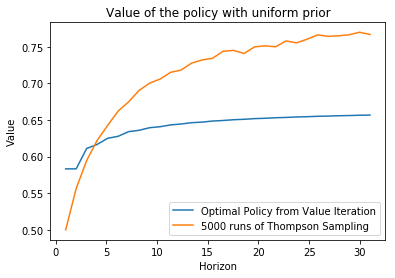

In [66]:
plt.plot(np.linspace(1,31,30),values_H, label='Optimal Policy from Value Iteration')
plt.plot(np.linspace(1,31,30),values_Thompson, label='5000 runs of Thompson Sampling')
plt.xlabel('Horizon')
plt.ylabel('Value')
plt.title('Value of the policy with uniform prior')
plt.legend()